## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [ ]:
# can I do: output = !pip install ipympl?
# !pip install ipympl

In [ ]:
# this shows ipympl is not in the JaxEnv backend
# !conda list ipympl

In [ ]:
#!nvidia-smi

In [ ]:
from platform import python_version
print(python_version())

In [3]:
%matplotlib inline
# %matplotlib ipympl
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import sis, epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel

import optax
tfd = tfp.distributions


from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate

from ipdb import set_trace

# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/Users/xiaoshenghuang/miniforge3/lib/python3.9/os.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/model.py


1

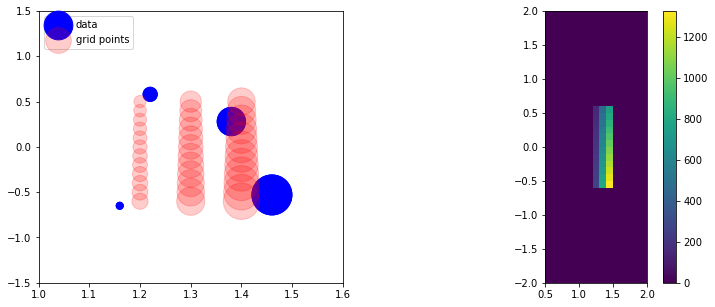

In [4]:
'''
Interpolation example: interpolate grid points onto "data"

Note: origin='lower' for imshow
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

u = np.array([1.22, 1.38, 1.46, 1.16])
v = np.array([0.58, 0.28, -0.53, -0.65])
uvpix = np.array([200, 800, 1600, 50])
ax1.scatter(u, v, s=uvpix, c='b', label='data')

h = interpolate.interp2d(u, v, uvpix, fill_value=0.0)

ulo, uhi = 0.5, 2
vlo, vhi = -2, 2
u1 = np.arange(ulo, uhi, 0.1)
v1 = np.arange(vlo, vhi, 0.1)

extent = [ulo, uhi, vlo, vhi]

uu, vv = np.meshgrid(u1, v1)

ax1.scatter(u, v, s=uvpix, c='b')
ax1.set_xlim(1.0, 1.6)
ax1.set_ylim(-1.5, 1.5)
newpix1 = h(u1, v1)

u1.shape, v1.shape, newpix1.shape
ax1.scatter(uu.flatten(), vv.flatten(), s=newpix1.flatten(), c='r', alpha=0.2, label='grid points')
ax1.legend(loc='upper left')

im = ax2.imshow(newpix1, origin='lower', extent=extent)
fig.colorbar(im)

In [5]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)


# more readable form 
def extract_params(best_params):

    # mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    # shear_params = ['gamma1', 'gamma2']
    mass_params = ['theta_E', 'center_x', 'center_y']

    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')


center: 60
beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


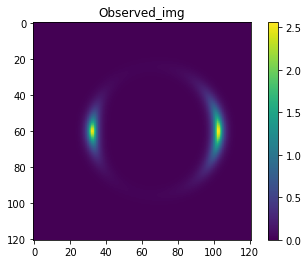

theta_E location in pixels: 94.0


In [310]:
delta_pix = 0.04
num_pix = 121
ctr = num_pix//2
supersample = 1

print('center:', ctr)

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
phys_model = PhysicalModel([sis.SIS()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

# background_rms, exp_time = 0.2, 100

background_rms, exp_time = 2e-6, 1e6


theta_E = 1.4
theta_E_pix = theta_E / delta_pix

lens_ctrx, lens_ctry = 0.0, 0.

src_ctrx, src_ctry = 0.3, 0.  #0.5, 0.


# # Now I make up other systems

# truth = [[
#     {'theta_E': theta_E, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-6, 'center_x': 0.0, 'center_y': 0.0},
#     {'gamma1': 1e-6, 'gamma2': 1e-6}
# ], [
#     {'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 100.}
# ], [
#     {'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': 0.0, 'center_y': 0.5, 'Ie': 500.}
# ]]


lens_params = [{'theta_E': theta_E, 'center_x': lens_ctrx, 'center_y': lens_ctry}]
source_light = [{'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': src_ctrx, 'center_y': src_ctry, 'Ie': 500.}]


truth = [lens_params, 
        [{'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 1e-3}], 
        source_light]

noiseless_img = lens_sim.simulate(truth)
observed_img = noiseless_img + \
                np.random.normal(0, background_rms, noiseless_img.shape) + \
                np.random.poisson(noiseless_img/exp_time, noiseless_img.shape)
plt.imshow(observed_img)

# observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.imshow(observed_img)
plt.colorbar()
plt.title('Observed_img')
plt.show()

print('theta_E location in pixels:', theta_E//delta_pix + ctr)

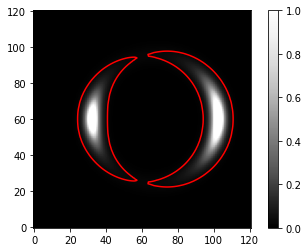

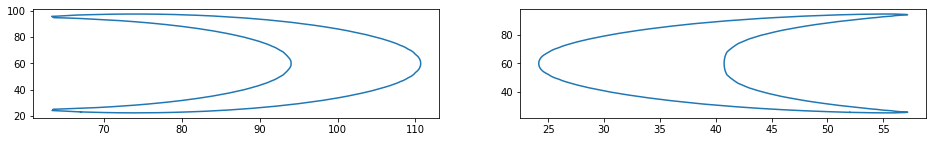

In [311]:

import matplotlib.patches as patches
from matplotlib.path import Path

con_levels = [0.027] #[0.001]

obsim = plt.imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower', vmin=0, vmax=1)


plt.colorbar(obsim)

X, Y = np.meshgrid(np.linspace(0, num_pix - 1, num_pix), np.linspace(0, num_pix - 1, num_pix))
cs = plt.contour(X, Y, observed_img, con_levels, colors='r')


num_axes = len(cs.collections[0].get_paths())


fig, axes = plt.subplots(1, num_axes, figsize=(16, 2))

for i, path in enumerate(cs.collections[0].get_paths()):
    verts = path.vertices
    xc, yc = verts[:, 0], verts[:, 1]
    axes[i].plot(xc, yc)


n_subfigs = 4
axes = []*n_subfigs
fig_h = 4


beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>}
shapes of beta_x, beta_y: (121, 121, 1) (121, 121, 1)


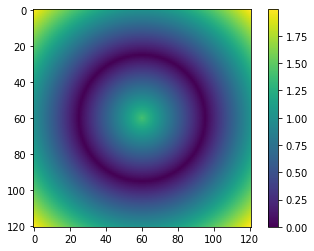

In [312]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [313]:
## One has to be very careful with shape!!!

from objax.functional import average_pool_2d
f_xi = jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...] 
f_yi = jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...] 


# f_yi_newaxis = f_yi_sq[jnp.newaxis, jnp.newaxis, ...]

print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

      
# # size = (lens_sim.supersample, lens_sim.supersample)
# # print(size, f_xi_sq.shape)
# # f_xi_downsamp = average_pool_2d(f_xi_newaxis, size=(lens_sim.supersample, lens_sim.supersample), padding="SAME") 
f_xi_downsamp = average_pool_2d(f_xi, size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(f_yi, size=lens_sim.supersample, padding="SAME") 


# f_yi_downsamp = average_pool_2d(f_yi_newaxis, size=lens_sim.supersample, padding="SAME") 


# # print(f_xi_downsamp.shape)

f_xi_downsamp.shape, f_yi_downsamp.shape
# # f_xi_sq.shape, type(f_xi), lens_sim.supersample

(1, 1, 121, 121) (1, 1, 121, 121)


((1, 1, 121, 121), (1, 1, 121, 121))

In [218]:
## One has to be very careful with shape!!!
a = jnp.array(np.random.random((1, 1, 16, 16)))
b = average_pool_2d(a, size=(2, 2)) 
c = average_pool_2d(a, size=2)
a.shape, b.shape, c.shape

((1, 1, 16, 16), (1, 1, 8, 8), (1, 1, 8, 8))

(121, 121)
(14641,)


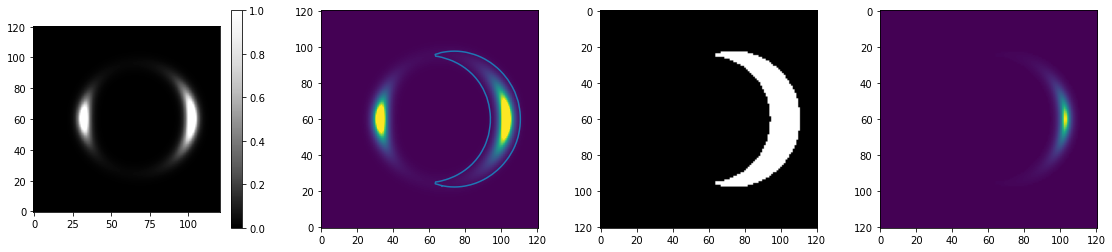

In [314]:
# To get the BIG arc


fig, axes = plt.subplots(1, n_subfigs, figsize=(fig_h*n_subfigs*1.2, fig_h))
axes[0].set_aspect('equal')

# Z = f(X, Y, pts)
obsim = axes[0].imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower', vmin=0, vmax=1)
plt.colorbar(obsim, ax=axes[0])


idx_cont = [0, 1]
verts = np.array([[], []]).T

for i, idx in enumerate(idx_cont):
    if i == 0 or i == 4: 
        # break
        verts = np.concatenate((verts, cs.collections[0].get_paths()[idx].vertices), axis=0)

    
# verts = cs.collections[0].get_paths()[1].vertices


xc, yc = verts[:, 0], verts[:, 1]
axes[1].plot(xc, yc)

obsim = axes[1].imshow(observed_img, origin='lower', vmin=0, vmax=1)

print(X.shape)
path = Path(verts)
points = np.vstack((X.flatten(), Y.flatten())).T

counterarcmask = path.contains_points(points)
print(counterarcmask.shape)



# bigarcmask = grid.reshape((116,116))
counterarcmask = counterarcmask.reshape((num_pix, num_pix))

axes[2].imshow(counterarcmask, cmap='gray')
# plt.colorbar()
counterarcmask.shape
# print grid

counterarc = observed_img * counterarcmask
axes[3].imshow(counterarc) #, origin='lower')
# plt.colorbar()

f_xi_ca = f_xi_downsamp * counterarcmask
f_yi_ca = f_yi_downsamp * counterarcmask

In [221]:
f_xi.shape, counterarcmask.shape

((242, 242, 1), (14641,))

In [155]:
counterarcmask.shape

(481, 481)

35.000004 35.000004


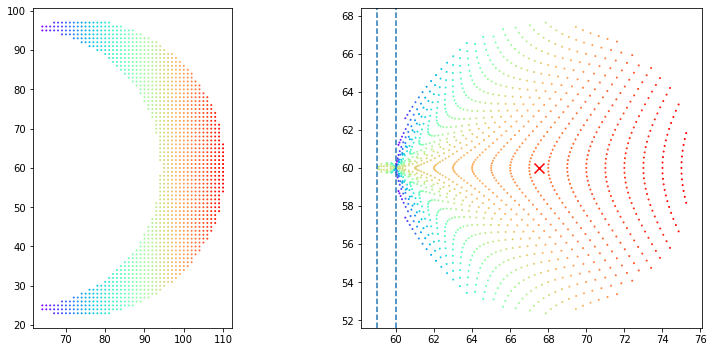

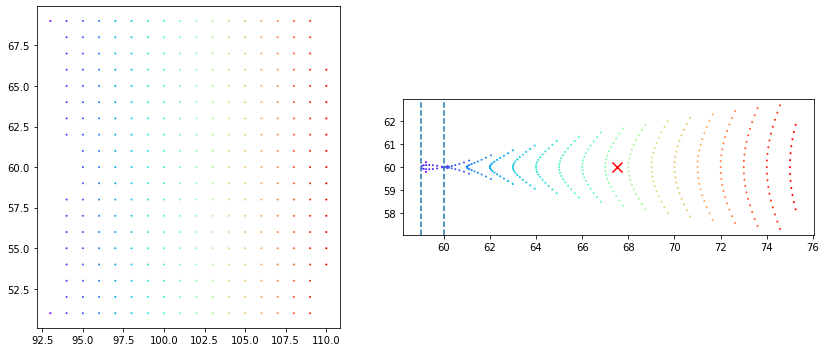

In [315]:
'''
Now delens:
'''
alfx_pix = np.squeeze(f_xi_downsamp) / delta_pix
alfy_pix = np.squeeze(f_yi_downsamp) / delta_pix

arcxy = np.where(counterarcmask > 0)

# print('alfx:', alfx_pix[arcxy])
# print('alfy:', alfx_pix[arcxy])

# # print('image flux:', img[goodidx])
# # print('image x:', goodxy[0])
# # print('image y:', goodxy[1])

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]


hiy = np.percentile(arcy, 90)
idx = arcy >= hiy

arcx_hiy = arcx[idx]
arcy_hiy = arcy[idx]

srcx_hiy = srcy[idx]
srcy_hiy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(arcx, arcy, c=arcx, cmap='rainbow', s=1)
# ax1.plot(arcx, arcy, '.')
# ax1.plot(arcx_hiy, arcy_hiy, 'r.')

ax1.set_aspect('equal')

ax2.scatter(srcx, srcy, c=arcx, cmap='rainbow', s=1)
ax2.axvline(60.0, ls='--')
ax2.axvline(59.0, ls='--')

# ax2.plot(srcx, srcy, '.', ms=1)
# ax2.plot(srcx_hiy, srcy_hiy, 'r.')

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
plt.tight_layout()
print(alfx_pix.max(), alfy_pix.max())

# zoom on the flat part

arc_loc = ctr + theta_E_pix
arc_w = 40
arc_h = 40

idx1 = (arcx > arc_loc - arc_w/1) * (arcy > ctr - arc_h/0.6) * (arcy < ctr + arc_h/0.6)
idx2 =  (arcy > ctr + arc_h/4) + (arcy < ctr - arc_h/4)
idx3 =  (arcy < ctr + arc_h/4) * (arcy > ctr - arc_h/4)

# idx = idx1 * idx2
idx = idx3

flat_arcx = arcx[idx]
flat_arcy = arcy[idx]

flat_srcx = srcx[idx]
flat_srcy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(flat_arcx, flat_arcy, c=flat_arcx, cmap='rainbow', s=1)
# ax1.plot(arcx, arcy, '.')
# ax1.plot(arcx_hiy, arcy_hiy, 'r.')

ax1.set_aspect('equal')

ax2.scatter(flat_srcx, flat_srcy, c=flat_arcx, cmap='rainbow', s=1)
# ax2.plot(srcx, srcy, '.', ms=1)
# ax2.plot(srcx_hiy, srcy_hiy, 'r.')

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
ax2.axvline(60.0, ls='--')
ax2.axvline(59.0, ls='--')

plt.tight_layout()




In [79]:
srcx = np.array(srcx)
srcy = np.array(srcy)
srcpix = np.array(observed_img[arcxy])
print(type(srcx), type(srcy), type(srcpix))
print(srcx.shape, srcy.shape, srcpix.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(797,) (797,) (797,)


beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


(10.0, 110.0)

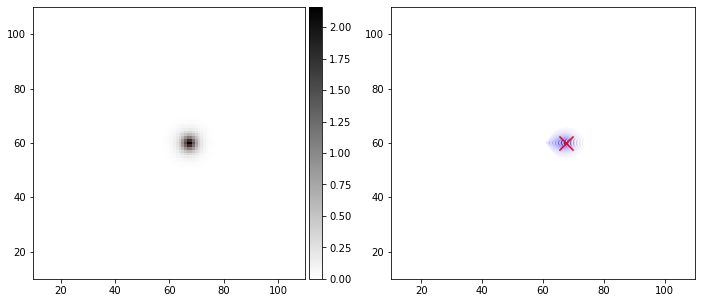

In [80]:
alphas = srcpix/10

wid = 50
xlo, xhi, ylo, yhi = ctr-wid, ctr+wid, ctr-wid, ctr+wid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
src_img = lens_sim.simulate([[{'theta_E': 1e-8, 'center_x': 1e-10, 'center_y': 1e-10}], [], source_light])
im = ax1.imshow(src_img, cmap='gray_r', interpolation='none')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax1.scatter(srcx, srcy, s=5, alpha=(alphas/30), color='r')
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)


ax2.scatter(srcx, srcy, s=1, alpha=alphas, color='b')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=200, marker='x', color='r')
ax2.set_xlim(xlo, xhi)
ax2.set_ylim(ylo, yhi)

In [81]:
src_ctrx/delta_pix

7.5

In [82]:
print(srcx.shape, srcy.shape, srcpix.shape)
print(src_img.max(), src_img.min(), src_img.mean(), src_img.dtype)
print(srcpix.max(), srcpix.min(), srcpix.mean(), srcpix.dtype)

(797,) (797,) (797,)
2.1601377 4.2303652e-26 0.0040808697 float32
2.5716317 0.100067765 0.47916242 float32


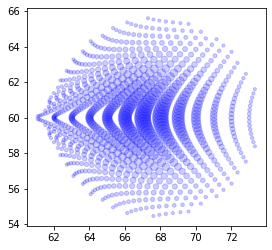

In [91]:
# size prop to to flux
plt.scatter(srcx, srcy, c='b', s=np.int64(srcpix*100), alpha=0.2); ax = plt.gca(); ax.set_aspect('equal')

In [89]:
'''
Looks to me that scipy kind of sets a rectangular box as bounds -- not the smarest thing to do

also: look into the warning message

'''

# ********************* for 480 pixels, this line takes 5 min to run
g = interpolate.interp2d(srcx, srcy, srcpix, fill_value=0.0, kind='quintic')



/Users/xiaoshenghuang/miniforge3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=30,27 m=797 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


xlo, xhi 40 80
srcxlo, srcxhi 50 90


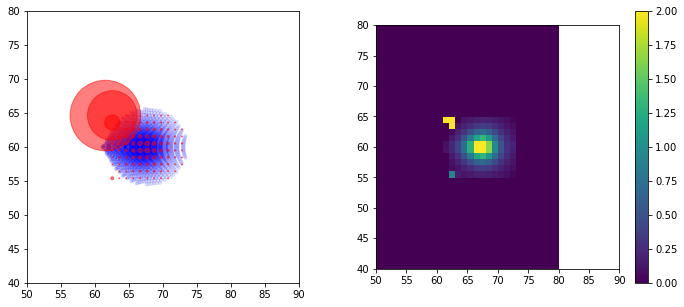

In [90]:
wid = 20

num_grid = wid * 2

xlo, xhi = ctr - wid, ctr + wid
ylo, yhi = ctr - wid, ctr + wid
xsrc = np.linspace(xlo, xhi, num_grid)
ysrc = np.linspace(ylo, yhi, num_grid)

xxsrc, yysrc = np.meshgrid(xsrc, ysrc)

src_intp = g(xsrc, ysrc)

shift = 10

srcxlo, srcxhi = ctr + shift - wid, ctr + shift + wid
srcylo, srcyhi = ctr - wid, ctr + wid

print('xlo, xhi', xlo, xhi)
print('srcxlo, srcxhi', srcxlo, srcxhi)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(srcx, srcy, c='b', s=np.int64(srcpix*100), alpha=0.1)
ax1.scatter(xxsrc.flatten(), yysrc.flatten(), s=np.int64(src_intp.flatten()*10), c='r', alpha=0.5)
# plt.xlim(32, 39)
# plt.ylim(28, 31)
ax1.set_aspect('equal')
ax1.set_xlim(srcxlo, srcxhi)
ax1.set_ylim(srcylo, srcyhi)


extent = [xlo, xhi, ylo, yhi]
im = ax2.imshow(src_intp, extent=extent, origin='lower', vmin=0, vmax=2) #, cmap='gray')
ax2.set_xlim(srcxlo, srcxhi)
ax2.set_ylim(srcylo, srcyhi)
fig.colorbar(im)

# im = ax2.imshow(src_intp.T, origin='lower', extent=extent, vmin=0, vmax=2) #, cmap='gray')
# ax2.set_xlim(srcxlo, srcxhi)
# ax2.set_ylim(srcylo, srcyhi)
# fig.colorbar(im)

In [ ]:
plt.plot(arange(10))

In [ ]:
print(src_intp.max(), src_intp.min(), src_intp.mean())
print(srcpix.max(), srcpix.min(), srcpix.mean())
src_intp_rescl = src_intp * srcpix.max() / src_intp.max()

print(src_intp_rescl.max(), src_intp_rescl.min(), src_intp_rescl.mean())
idx = src_intp_rescl > 0
print(idx.sum())

In [ ]:
plt.imshow(src_intp.T, vmin=0, vmax=3, origin='lower') #, cmap='gray')
plt.colorbar()

In [ ]:
srcx.shape, arcxy[0].shape, observed_img[arcxy].shape

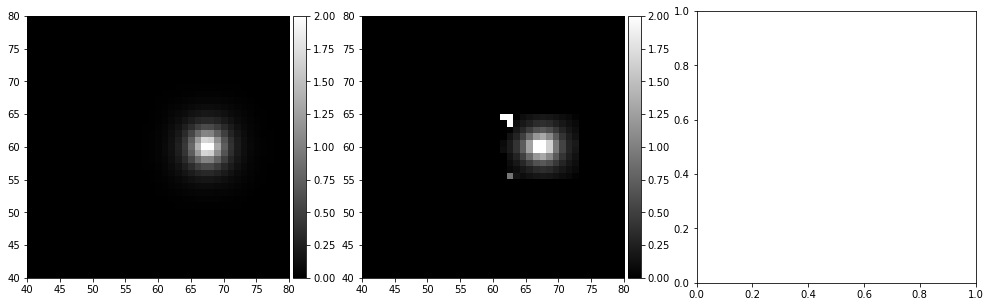

In [101]:
# comparing the true source
from mpl_toolkits.axes_grid1 import make_axes_locatable

alphas = srcpix/8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
src_img = lens_sim.simulate([[{'theta_E': 1e-8, 'center_x': 1e-10, 'center_y': 1e-10}], [], source_light])
im1 = ax1.imshow(src_img, vmin=0, vmax=2., cmap='gray')
ax1.axis(extent)
# ax1.scatter(srcy, srcx, s=5, alpha=alphas, color='r')
# im1 = ax1.scatter(yysrc.flatten(), xxsrc.flatten(), s=np.int64(src.flatten()*5), c='r', alpha=0.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')



im2 = ax2.imshow(src_intp, origin='lower', extent=extent, vmin=0, vmax=2, cmap='gray') #, cmap='gray')
# ax2.set_xlim(srcxlo, srcxhi)
# ax2.set_ylim(srcylo, srcyhi)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# res = (src_img - src_intp)/src_img
# resim = ax3.imshow(resid, vmin=-1, vmax=1, cmap='gray')
# ax3.set_xlim(srcxlo, srcxhi)
# ax3.set_ylim(srcylo, srcyhi)
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(resim, cax=cax, orientation='vertical')

# fig.colorbar(resim)



In [ ]:
# I really don't understand why img_X and img_Y have structure
# I think the reason is so that they are measured from the center outside, linearly
# then they seem to be right

imgX = lens_sim.img_X
imgY = lens_sim.img_Y

img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

In [ ]:
plt.plot(img_t1[30, :])
pix = np.linspace(30, 60, 30)
plt.plot(pix, (pix-30)*delta_pix, '.')

In [ ]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [ ]:
plt.plot(beta_t1[30, :])

In [ ]:
f_xi_t1, f_yi_t1 = f_xi, f_yi
f_t1 = np.sqrt(f_xi_t1**2 + f_yi_t1**2)

plt.imshow(f_t1)
plt.colorbar()

In [ ]:
f_t1.mean(), f_t1.max(), f_t1.min()

In [ ]:
imgX.shape, type(imgX)

In [ ]:
# size = 20
# xctr, yctr = size/2, size/2
# x = np.arange(size)
# y = np.arange(size)
# xx, yy = np.meshgrid(x, y)
# alph = 2.5

xx = np.squeeze(imgX)/delta_pix
yy = np.squeeze(imgY)/delta_pix
xctr, yctr = 30, 30


r_E = theta_E/delta_pix
print(xx.shape, type(xx))

def xderiv(x, y, theta_E, center_x, center_y):
    '''Have to define it outside gigalens, b/c otherwise:
    
    ----> 1 bx, bx, alfx, alfy = sis.SIS.deriv(imgX, imgY, **lens_params)
    TypeError: gigalens.jax.profiles.mass.sis.SIS.deriv() argument after ** must be a mapping, not list
    
    '''
    _params = ["theta_E", "center_x", "center_y"]
    dx, dy = x - center_x, y - center_y
    R = np.sqrt(dx ** 2 + dy ** 2)
    a = np.where(R == 0, 0.0, theta_E / R)
    return a*R, a * dx, a * dy

print(r_E, xctr, yctr)
alf, alfx, alfy = xderiv(xx, yy, r_E, xctr, yctr)

alf_recalc = np.sqrt(alfx**2 + alfy**2)
plt.imshow(alf_recalc)
plt.colorbar()

plt.figure()
plt.imshow(alf)
plt.colorbar()

In [ ]:
alf

In [ ]:
r = np.sqrt(xx**2 + yy**2)
plt.imshow(r)
plt.colorbar()

In [ ]:
print(**lens_params[0])

In [ ]:
u = lens_params[0]
u

In [ ]:
plt.plot(f_t1[30, :])

In [ ]:
'''
Here I get

shapes of img_X, img_Y: (120, 120, 1) (120, 120, 1)
shapes of f_xi, f_yi: (120, 120, 1) (120, 120, 1)

'''

from objax.functional import average_pool_2d

# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


imgX = lens_sim.img_X
imgY = lens_sim.img_Y

print('shapes of imgX, imgY:', imgX.shape, imgY.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


ax1.imshow(img_X_t1)
ax1.set_title('img_X[..., 0]')
ax2.imshow(img_Y_t1)
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

f_xi_t1, f_yi_t1 = f_xi, f_yi

In [ ]:
img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

In [ ]:
beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [ ]:
    @functools.partial(jit, static_argnums=(0,))
    def _beta(self, lens_params: List[Dict]):
        beta_x, beta_y = self.img_X, self.img_Y
        lens_i = 0
        for lens, p in zip(self.phys_model.lenses, lens_params):
            print('beta for lens #{:d}'.format(lens_i))
            print('lens', lens)
            print('lens params', p)
            lens_i += 1
            f_xi, f_yi = lens.deriv(self.img_X, self.img_Y, **p)
            beta_x, beta_y = beta_x - f_xi, beta_y - f_yi
        return beta_x, beta_y, f_xi, f_yi 


# Next: delens using f_xi_t1, f_yi_t1 and see I recover the forward model source

In [ ]:
# ********************************
# on M1, 100 samples, 200 steps: 5 min to run -- so be careful
# ********************************

map_samples = 100

map_steps = 200
transition_steps = 200

seed, lr_start, lr_end, pwr = 0, -1e-2, -1e-2/3, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

In [ ]:
import pickle
with open('map_est_2022_09_14-18:12_sim.pickle', 'rb') as f:
    # map_estimate = pickle.load(f)
    map_estimate, chi2_hist, hyper_params = pickle.load(f)
map_estimate.shape

In [ ]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

# lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min, hyper_p)
# plt.ylim(2.5, 6)
plt.ylim(0.9, 20)
plt.show()


In [ ]:

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_estimate))
# these two lines can take long to run on cpu
# 
lps, chi2 = prob_model.log_prob(lens_sim, map_estimate)
# recon = lens_sim.lstsq_simulate(prob_model.bij.forward(list(map_estimate.T)), 
#                                 obs_data, prob_model.err_map)[np.nanargmax(lps)]

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))

print(map_estimate.shape)
print(np.nanargmax(lps))
print(map_estimate[np.nanargmax(lps)].shape)


In [ ]:
print(lps.shape)

idx_map_best = np.argmin(chi2)
print('best idx for map:', idx_map_best)

print(chi2.min())

chi2[idx_map_best]

In [ ]:
'''
The gist of this cell is that I don't understand the shape:

shapes of img_X, img_Y: (120, 120, 22) (120, 120, 22)
shapes of f_xi, f_yi: (120, 120, 22) (120, 120, 22)

When the last value is the number of parameters.

'''

from objax.functional import average_pool_2d

map_est = map_estimate[idx_map_best]

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_est))
# this line can take long to run on cpu
lps, chi2 = prob_model.log_prob(lens_sim, map_est)

print(chi2.shape)
print(chi2)
phys_params = prob_model.bij.forward(list(map_est.T))

params = phys_params
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)
print(phys_params[0][0])

In [ ]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)
# prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
# model_seq = ModellingSequence(phys_model, prob_model, sim_config)

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

In [ ]:
from objax.functional import average_pool_2d

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)


f_xi_t22, f_yi_t22 = f_xi, f_yi

In [ ]:
# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
# extract_params(best_params)
# print('Compared with truth: \n')

print('The truth parameters:')
extract_params(truth)

print('The best_params:')
extract_params(best_params)

print('The phys_params:')
extract_params(phys_params)
# chi2_ar = chi2_arr[-100:]
# print('min chi2: {:4.3f}'.format(chi2_arr.min()))

In [ ]:
# compare best-fit parameters with observed image
from astropy import modeling

plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(142)
simulated = lens_sim.simulate(truth)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(143)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)

norm_resid = np.asarray(resid/err_map)

plt.imshow(norm_resid, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

plt.subplot(144)
bin_h, bins, _ = plt.hist(norm_resid.flatten(), bins=100)
x = (bins[:-1] + bins[1:])/2
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, x, bin_h)

plt.plot(x, fitted_model(x))
plt.title(r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(fitted_model.mean.value, fitted_model.stddev.value))

print('Chi-square:', np.mean((resid/err_map)**2))




In [ ]:
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


In [ ]:
from copy import copy
no_lens = copy(truth)
no_lens[0][0]['theta_E'] = 1e-12
no_lens

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

In [ ]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# x = lens_sim_t.simulate([truth[0], truth[2], []])
# x = lens_sim_t.simulate(truth)
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lens_plot.lens_model_plot(ax1, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
simulated = lens_sim.simulate([[], truth[2], []])

scale_extent = 2.0
ext_arcsec = ((num_pix+1)*delta_pix)/scale_extent
print('num_pix, delta_pix, scale_extent, ext_arcsec:', num_pix, delta_pix, scale_extent, ext_arcsec)

extent = ext_arcsec, -ext_arcsec, -ext_arcsec, ext_arcsec
print('extent', extent)

ax1.plot(0, 0, 'x', ms=10, color='red')
ax1.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1), extent=extent)

lens_plot.lens_model_plot(ax2, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
ax2.plot(0, 0, 'x', ms=10, color='red')




# ax.imshow(simulated, vmin=0, vmax=1, extent=extent)

# # source_img = np.rot90(np.rot90(x))
# source_img = x

# ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)

In [ ]:
simulated.max()

In [ ]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([no_lens[0], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

# print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

# scale_extent = 2

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# # source_img = np.rot90(np.rot90(source_img))
# # extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# # ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
# ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
# ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
# ax.grid(axis='both')


# ax2 = ax.twinx().twiny() #here is the trick!
# ax2.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)) #, cmap='GnBu')

# # ax2.tick_params(axis='both', labelcolor='blue')
# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
# ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# # ax2.grid(which='major', axis='both')
# # ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

In [ ]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(top=True, labeltop=True, right=True, labelright=True)

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

ax.grid(which='major')


In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)


# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# ax.grid(which='major')

ax2 = ax.twiny() #here is the trick!
ax2.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)

# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=False, labeltop=False, right=False, labelright=False)
# # Major ticks
# # ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# # ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# ax2.grid(which='major', axis='x')


In [ ]:
truth[2][0]

In [ ]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

In [ ]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

## Next: add cautic and critical curves -- reproduce one of the four archetypes

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

nx, ny = 3, 3

np.random.seed(seed=1)
img = np.reshape(np.random.rand(nx*ny), newshape=(nx, ny))

im = ax.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')

# Major ticks
ax.set_xticks(np.arange(0, nx, 1))
ax.set_yticks(np.arange(0, ny, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, nx+1, 1))
ax.set_yticklabels(np.arange(1, ny+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', axis='both')

ax2 = ax.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax2.set_xticks(np.arange(0, nx, 1))
ax2.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax2.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax2.grid(which='major', axis='y')



ax3 = ax2.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax3.set_xticks(np.arange(0, nx, 1))
ax3.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax3.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax3.grid(which='major', axis='y')
plt.show()

